In [14]:
# import
import argparse
from collections import deque
import itertools
import random
import time

import gym
import torch
import torch.nn
import torch.nn.functional
import numpy
import matplotlib.pyplot

In [29]:
# variable
MEMORY_CAPACITY = 10000
BATCH_SIZE = 128
WARMUP_STEP = 10000
LEARNING_RATE = 0.0005
GAMMA = 0.99
UPDATA_TARGET_NETWORK_ITERATION = 100
environment = gym.make('CartPole-v0')
environment = env.unwrapped
TRAIN_EPISODE = 1000
TEST_EPISODE = 10

In [16]:
# class
# 目標網路/行為網路
class Network(torch.nn.Module):
    def __init__(self, state, action):
        super(Network, self).__init__()
        self.fc1 = torch.nn.Linear(state, 32)
        self.fc1.weight.data.normal_(0, 0.1)
        self.output = torch.nn.Linear(32, action)
        self.output.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        # action value
        x = self.output(x)
        return x


class DQN(object):
    def __init__(self, state, action):
        self.behaviorNet, self.targetNet = Network(state, action), Network(
            state, action)
        self.epsilon = 1
        self.epsilonDecay = 0.995
        self.epsilonMin = 0.001
        self.learningStepCount = 0
        self.memoryCount = 0
        self.memory = numpy.zeros((MEMORY_CAPACITY, state * 2 + 2))
        self.optimizer = torch.optim.Adam(
            self.behaviorNet.parameters(), lr=LEARNING_RATE)
        self.loss = torch.nn.MSELoss()
        self.state = state
        self.action = action

    def chooseAction(self, x):
        x = torch.FloatTensor(x)
        x = torch.unsqueeze(x, 0)
        if self.epsilon > self.epsilonMin:
            self.epsilon = self.epsilon * self.epsilonDecay
        else:
            self.epsilon = self.epsilonMin

        # input only one sample
        if numpy.random.uniform() > self.epsilon:
            actions_value = self.behaviorNet.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0]
        # random
        else:
            action = numpy.random.randint(0, self.action)

        return action

    def storeTransition(self, S, A, R, S2):
        transition = numpy.hstack((S, [A, R], S2))
        index = self.memoryCount % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memoryCount += 1

    def learn(self):
        # network update
        if self.learningStepCount % UPDATA_TARGET_NETWORK_ITERATION == 0:
            self.targetNet.load_state_dict(self.behaviorNet.state_dict())
        self.learningStepCount += 1

        # random sample batch
        sampleIndex = numpy.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batchMemory = self.memory[sampleIndex, :]
        batchS = torch.FloatTensor(batchMemory[:, :self.state])
        batchA = torch.LongTensor(
            batchMemory[:, self.state:self.state + 1].astype(int))
        batchR = torch.FloatTensor(
            batchMemory[:, self.state + 1:self.state + 2])
        batchS2 = torch.FloatTensor(batchMemory[:, -self.state:])

        # evaluate
        qEval = self.behaviorNet(batchS).gather(1, batchA)
        qNext = self.targetNet(batchS2).detach()
        qTarget = batchR + GAMMA * \
            qNext.max(1)[0].view(BATCH_SIZE, 1)
        loss = self.loss(qEval, qTarget)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

TIMES 0
----------TRAINING----------
[ 0 ] 40.0
[ 1 ] 17.0
[ 2 ] 10.0
[ 3 ] 12.0
[ 4 ] 7.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 16.0
[ 8 ] 8.0
[ 9 ] 10.0
[ 10 ] 9.0
[ 11 ] 7.0
[ 12 ] 8.0
[ 13 ] 9.0
[ 14 ] 9.0
[ 15 ] 10.0
[ 16 ] 9.0
[ 17 ] 7.0
[ 18 ] 10.0
[ 19 ] 9.0
[ 20 ] 9.0
[ 21 ] 9.0
[ 22 ] 8.0
[ 23 ] 9.0
[ 24 ] 10.0
[ 25 ] 8.0
[ 26 ] 10.0
[ 27 ] 7.0
[ 28 ] 10.0
[ 29 ] 10.0
[ 30 ] 8.0
[ 31 ] 8.0
[ 32 ] 8.0
[ 33 ] 8.0
[ 34 ] 8.0
[ 35 ] 9.0
[ 36 ] 11.0
[ 37 ] 8.0
[ 38 ] 8.0
[ 39 ] 10.0
[ 40 ] 8.0
[ 41 ] 8.0
[ 42 ] 6.0
[ 43 ] 10.0
[ 44 ] 7.0
[ 45 ] 7.0
[ 46 ] 7.0
[ 47 ] 7.0
[ 48 ] 6.0
[ 49 ] 11.0
[ 50 ] 8.0
[ 51 ] 7.0
[ 52 ] 8.0
[ 53 ] 6.0
[ 54 ] 7.0
[ 55 ] 8.0
[ 56 ] 8.0
[ 57 ] 7.0
[ 58 ] 8.0
[ 59 ] 8.0
[ 60 ] 9.0
[ 61 ] 7.0
[ 62 ] 7.0
[ 63 ] 8.0
[ 64 ] 8.0
[ 65 ] 7.0
[ 66 ] 8.0
[ 67 ] 8.0
[ 68 ] 8.0
[ 69 ] 8.0
[ 70 ] 7.0
[ 71 ] 6.0
[ 72 ] 7.0
[ 73 ] 7.0
[ 74 ] 7.0
[ 75 ] 8.0
[ 76 ] 8.0
[ 77 ] 8.0
[ 78 ] 7.0
[ 79 ] 7.0
[ 80 ] 8.0
[ 81 ] 8.0
[ 82 ] 7.0
[ 83 ] 7.0
[ 84 ] 8.0
[ 85 ] 8.0
[ 86 ] 7.0

[ 671 ] 6.0
[ 672 ] 8.0
[ 673 ] 8.0
[ 674 ] 9.0
[ 675 ] 8.0
[ 676 ] 7.0
[ 677 ] 7.0
[ 678 ] 8.0
[ 679 ] 7.0
[ 680 ] 8.0
[ 681 ] 7.0
[ 682 ] 8.0
[ 683 ] 8.0
[ 684 ] 7.0
[ 685 ] 8.0
[ 686 ] 6.0
[ 687 ] 7.0
[ 688 ] 8.0
[ 689 ] 7.0
[ 690 ] 9.0
[ 691 ] 8.0
[ 692 ] 8.0
[ 693 ] 7.0
[ 694 ] 8.0
[ 695 ] 8.0
[ 696 ] 8.0
[ 697 ] 8.0
[ 698 ] 9.0
[ 699 ] 7.0
[ 700 ] 7.0
[ 701 ] 8.0
[ 702 ] 7.0
[ 703 ] 8.0
[ 704 ] 8.0
[ 705 ] 8.0
[ 706 ] 8.0
[ 707 ] 8.0
[ 708 ] 7.0
[ 709 ] 8.0
[ 710 ] 7.0
[ 711 ] 7.0
[ 712 ] 7.0
[ 713 ] 8.0
[ 714 ] 8.0
[ 715 ] 7.0
[ 716 ] 7.0
[ 717 ] 6.0
[ 718 ] 8.0
[ 719 ] 7.0
[ 720 ] 6.0
[ 721 ] 7.0
[ 722 ] 7.0
[ 723 ] 7.0
[ 724 ] 8.0
[ 725 ] 6.0
[ 726 ] 8.0
[ 727 ] 8.0
[ 728 ] 8.0
[ 729 ] 8.0
[ 730 ] 7.0
[ 731 ] 7.0
[ 732 ] 8.0
[ 733 ] 6.0
[ 734 ] 8.0
[ 735 ] 7.0
[ 736 ] 8.0
[ 737 ] 8.0
[ 738 ] 8.0
[ 739 ] 8.0
[ 740 ] 8.0
[ 741 ] 8.0
[ 742 ] 8.0
[ 743 ] 8.0
[ 744 ] 8.0
[ 745 ] 8.0
[ 746 ] 6.0
[ 747 ] 7.0
[ 748 ] 6.0
[ 749 ] 8.0
[ 750 ] 7.0
[ 751 ] 7.0
[ 752 ] 8.0
[ 753 ] 8.0
[ 75

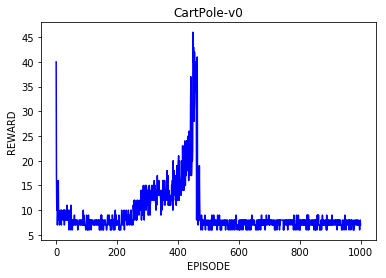

----------TESTING----------
[ 0 ] 9.0
[ 1 ] 8.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 11.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.9
TIMES 1
----------TRAINING----------
[ 0 ] 11.0
[ 1 ] 27.0
[ 2 ] 33.0
[ 3 ] 8.0
[ 4 ] 17.0
[ 5 ] 13.0
[ 6 ] 15.0
[ 7 ] 33.0
[ 8 ] 8.0
[ 9 ] 10.0
[ 10 ] 11.0
[ 11 ] 12.0
[ 12 ] 8.0
[ 13 ] 9.0
[ 14 ] 14.0
[ 15 ] 9.0
[ 16 ] 8.0
[ 17 ] 8.0
[ 18 ] 7.0
[ 19 ] 7.0
[ 20 ] 8.0
[ 21 ] 10.0
[ 22 ] 9.0
[ 23 ] 6.0
[ 24 ] 8.0
[ 25 ] 7.0
[ 26 ] 9.0
[ 27 ] 6.0
[ 28 ] 11.0
[ 29 ] 11.0
[ 30 ] 7.0
[ 31 ] 8.0
[ 32 ] 12.0
[ 33 ] 7.0
[ 34 ] 8.0
[ 35 ] 9.0
[ 36 ] 7.0
[ 37 ] 8.0
[ 38 ] 9.0
[ 39 ] 8.0
[ 40 ] 10.0
[ 41 ] 7.0
[ 42 ] 7.0
[ 43 ] 6.0
[ 44 ] 8.0
[ 45 ] 7.0
[ 46 ] 7.0
[ 47 ] 9.0
[ 48 ] 8.0
[ 49 ] 8.0
[ 50 ] 6.0
[ 51 ] 8.0
[ 52 ] 7.0
[ 53 ] 8.0
[ 54 ] 8.0
[ 55 ] 8.0
[ 56 ] 8.0
[ 57 ] 8.0
[ 58 ] 8.0
[ 59 ] 6.0
[ 60 ] 8.0
[ 61 ] 7.0
[ 62 ] 7.0
[ 63 ] 6.0
[ 64 ] 8.0
[ 65 ] 9.0
[ 66 ] 7.0
[ 67 ] 8.0
[ 68 ] 7.0
[ 69 ] 8.0
[ 70 ] 8.0
[ 71 ] 6.0
[ 72 ] 6.0
[ 73 ] 8.0


[ 681 ] 8.0
[ 682 ] 7.0
[ 683 ] 7.0
[ 684 ] 6.0
[ 685 ] 7.0
[ 686 ] 8.0
[ 687 ] 8.0
[ 688 ] 7.0
[ 689 ] 8.0
[ 690 ] 7.0
[ 691 ] 8.0
[ 692 ] 7.0
[ 693 ] 7.0
[ 694 ] 7.0
[ 695 ] 6.0
[ 696 ] 7.0
[ 697 ] 6.0
[ 698 ] 8.0
[ 699 ] 8.0
[ 700 ] 7.0
[ 701 ] 8.0
[ 702 ] 8.0
[ 703 ] 7.0
[ 704 ] 8.0
[ 705 ] 6.0
[ 706 ] 8.0
[ 707 ] 6.0
[ 708 ] 6.0
[ 709 ] 6.0
[ 710 ] 7.0
[ 711 ] 6.0
[ 712 ] 8.0
[ 713 ] 8.0
[ 714 ] 6.0
[ 715 ] 7.0
[ 716 ] 7.0
[ 717 ] 8.0
[ 718 ] 6.0
[ 719 ] 9.0
[ 720 ] 7.0
[ 721 ] 8.0
[ 722 ] 8.0
[ 723 ] 6.0
[ 724 ] 7.0
[ 725 ] 7.0
[ 726 ] 7.0
[ 727 ] 7.0
[ 728 ] 9.0
[ 729 ] 7.0
[ 730 ] 7.0
[ 731 ] 6.0
[ 732 ] 6.0
[ 733 ] 7.0
[ 734 ] 8.0
[ 735 ] 8.0
[ 736 ] 6.0
[ 737 ] 7.0
[ 738 ] 8.0
[ 739 ] 8.0
[ 740 ] 8.0
[ 741 ] 8.0
[ 742 ] 8.0
[ 743 ] 8.0
[ 744 ] 6.0
[ 745 ] 6.0
[ 746 ] 8.0
[ 747 ] 7.0
[ 748 ] 8.0
[ 749 ] 7.0
[ 750 ] 7.0
[ 751 ] 6.0
[ 752 ] 6.0
[ 753 ] 7.0
[ 754 ] 8.0
[ 755 ] 8.0
[ 756 ] 8.0
[ 757 ] 7.0
[ 758 ] 8.0
[ 759 ] 8.0
[ 760 ] 8.0
[ 761 ] 9.0
[ 762 ] 9.0
[ 763 ] 8.0
[ 76

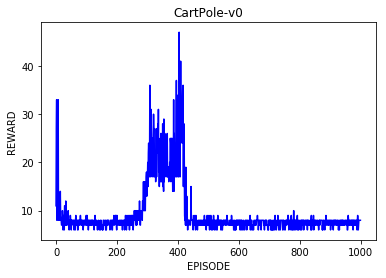

----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 8.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.8800000000000001
TIMES 2
----------TRAINING----------
[ 0 ] 26.0
[ 1 ] 36.0
[ 2 ] 14.0
[ 3 ] 34.0
[ 4 ] 9.0
[ 5 ] 19.0
[ 6 ] 8.0
[ 7 ] 15.0
[ 8 ] 12.0
[ 9 ] 20.0
[ 10 ] 6.0
[ 11 ] 10.0
[ 12 ] 8.0
[ 13 ] 9.0
[ 14 ] 11.0
[ 15 ] 6.0
[ 16 ] 11.0
[ 17 ] 9.0
[ 18 ] 7.0
[ 19 ] 8.0
[ 20 ] 10.0
[ 21 ] 7.0
[ 22 ] 8.0
[ 23 ] 7.0
[ 24 ] 7.0
[ 25 ] 8.0
[ 26 ] 7.0
[ 27 ] 6.0
[ 28 ] 8.0
[ 29 ] 10.0
[ 30 ] 8.0
[ 31 ] 8.0
[ 32 ] 7.0
[ 33 ] 8.0
[ 34 ] 9.0
[ 35 ] 7.0
[ 36 ] 9.0
[ 37 ] 10.0
[ 38 ] 9.0
[ 39 ] 8.0
[ 40 ] 6.0
[ 41 ] 8.0
[ 42 ] 8.0
[ 43 ] 6.0
[ 44 ] 7.0
[ 45 ] 8.0
[ 46 ] 7.0
[ 47 ] 10.0
[ 48 ] 6.0
[ 49 ] 9.0
[ 50 ] 7.0
[ 51 ] 7.0
[ 52 ] 7.0
[ 53 ] 9.0
[ 54 ] 8.0
[ 55 ] 9.0
[ 56 ] 7.0
[ 57 ] 7.0
[ 58 ] 7.0
[ 59 ] 8.0
[ 60 ] 8.0
[ 61 ] 8.0
[ 62 ] 6.0
[ 63 ] 9.0
[ 64 ] 8.0
[ 65 ] 7.0
[ 66 ] 8.0
[ 67 ] 8.0
[ 68 ] 8.0
[ 69 ] 7.0
[ 70 ] 7.0
[ 71 ] 7.0
[ 72 ] 8

[ 657 ] 7.0
[ 658 ] 8.0
[ 659 ] 8.0
[ 660 ] 7.0
[ 661 ] 8.0
[ 662 ] 8.0
[ 663 ] 7.0
[ 664 ] 7.0
[ 665 ] 6.0
[ 666 ] 8.0
[ 667 ] 7.0
[ 668 ] 7.0
[ 669 ] 8.0
[ 670 ] 9.0
[ 671 ] 7.0
[ 672 ] 8.0
[ 673 ] 7.0
[ 674 ] 7.0
[ 675 ] 7.0
[ 676 ] 7.0
[ 677 ] 6.0
[ 678 ] 6.0
[ 679 ] 8.0
[ 680 ] 7.0
[ 681 ] 7.0
[ 682 ] 6.0
[ 683 ] 7.0
[ 684 ] 8.0
[ 685 ] 7.0
[ 686 ] 7.0
[ 687 ] 8.0
[ 688 ] 9.0
[ 689 ] 8.0
[ 690 ] 8.0
[ 691 ] 7.0
[ 692 ] 7.0
[ 693 ] 7.0
[ 694 ] 8.0
[ 695 ] 7.0
[ 696 ] 8.0
[ 697 ] 7.0
[ 698 ] 8.0
[ 699 ] 8.0
[ 700 ] 7.0
[ 701 ] 8.0
[ 702 ] 7.0
[ 703 ] 7.0
[ 704 ] 8.0
[ 705 ] 8.0
[ 706 ] 7.0
[ 707 ] 7.0
[ 708 ] 7.0
[ 709 ] 7.0
[ 710 ] 8.0
[ 711 ] 7.0
[ 712 ] 8.0
[ 713 ] 8.0
[ 714 ] 8.0
[ 715 ] 8.0
[ 716 ] 6.0
[ 717 ] 7.0
[ 718 ] 7.0
[ 719 ] 7.0
[ 720 ] 9.0
[ 721 ] 6.0
[ 722 ] 8.0
[ 723 ] 7.0
[ 724 ] 8.0
[ 725 ] 7.0
[ 726 ] 8.0
[ 727 ] 6.0
[ 728 ] 8.0
[ 729 ] 7.0
[ 730 ] 7.0
[ 731 ] 8.0
[ 732 ] 8.0
[ 733 ] 6.0
[ 734 ] 8.0
[ 735 ] 7.0
[ 736 ] 8.0
[ 737 ] 8.0
[ 738 ] 6.0
[ 739 ] 7.0
[ 74

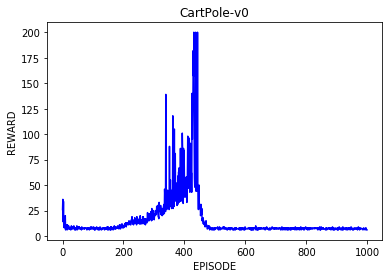

----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 8.0
MEANS 1.8800000000000001
TIMES 3
----------TRAINING----------
[ 0 ] 32.0
[ 1 ] 9.0
[ 2 ] 11.0
[ 3 ] 11.0
[ 4 ] 12.0
[ 5 ] 15.0
[ 6 ] 17.0
[ 7 ] 31.0
[ 8 ] 10.0
[ 9 ] 17.0
[ 10 ] 13.0
[ 11 ] 8.0
[ 12 ] 8.0
[ 13 ] 14.0
[ 14 ] 8.0
[ 15 ] 8.0
[ 16 ] 10.0
[ 17 ] 6.0
[ 18 ] 12.0
[ 19 ] 8.0
[ 20 ] 8.0
[ 21 ] 7.0
[ 22 ] 7.0
[ 23 ] 10.0
[ 24 ] 9.0
[ 25 ] 10.0
[ 26 ] 7.0
[ 27 ] 7.0
[ 28 ] 8.0
[ 29 ] 7.0
[ 30 ] 9.0
[ 31 ] 9.0
[ 32 ] 7.0
[ 33 ] 8.0
[ 34 ] 12.0
[ 35 ] 7.0
[ 36 ] 10.0
[ 37 ] 11.0
[ 38 ] 6.0
[ 39 ] 10.0
[ 40 ] 7.0
[ 41 ] 9.0
[ 42 ] 8.0
[ 43 ] 6.0
[ 44 ] 9.0
[ 45 ] 7.0
[ 46 ] 6.0
[ 47 ] 10.0
[ 48 ] 8.0
[ 49 ] 6.0
[ 50 ] 7.0
[ 51 ] 7.0
[ 52 ] 8.0
[ 53 ] 7.0
[ 54 ] 9.0
[ 55 ] 7.0
[ 56 ] 8.0
[ 57 ] 8.0
[ 58 ] 8.0
[ 59 ] 8.0
[ 60 ] 9.0
[ 61 ] 7.0
[ 62 ] 8.0
[ 63 ] 6.0
[ 64 ] 8.0
[ 65 ] 6.0
[ 66 ] 7.0
[ 67 ] 8.0
[ 68 ] 7.0
[ 69 ] 7.0
[ 70 ] 6.0
[ 71 ] 8.0
[ 7

[ 680 ] 8.0
[ 681 ] 8.0
[ 682 ] 8.0
[ 683 ] 8.0
[ 684 ] 8.0
[ 685 ] 6.0
[ 686 ] 7.0
[ 687 ] 7.0
[ 688 ] 7.0
[ 689 ] 6.0
[ 690 ] 8.0
[ 691 ] 8.0
[ 692 ] 7.0
[ 693 ] 6.0
[ 694 ] 7.0
[ 695 ] 7.0
[ 696 ] 8.0
[ 697 ] 7.0
[ 698 ] 8.0
[ 699 ] 7.0
[ 700 ] 8.0
[ 701 ] 8.0
[ 702 ] 7.0
[ 703 ] 7.0
[ 704 ] 6.0
[ 705 ] 8.0
[ 706 ] 7.0
[ 707 ] 7.0
[ 708 ] 6.0
[ 709 ] 8.0
[ 710 ] 9.0
[ 711 ] 7.0
[ 712 ] 8.0
[ 713 ] 7.0
[ 714 ] 7.0
[ 715 ] 6.0
[ 716 ] 6.0
[ 717 ] 6.0
[ 718 ] 7.0
[ 719 ] 8.0
[ 720 ] 7.0
[ 721 ] 8.0
[ 722 ] 8.0
[ 723 ] 8.0
[ 724 ] 7.0
[ 725 ] 8.0
[ 726 ] 7.0
[ 727 ] 7.0
[ 728 ] 8.0
[ 729 ] 7.0
[ 730 ] 7.0
[ 731 ] 7.0
[ 732 ] 7.0
[ 733 ] 8.0
[ 734 ] 7.0
[ 735 ] 7.0
[ 736 ] 8.0
[ 737 ] 8.0
[ 738 ] 8.0
[ 739 ] 8.0
[ 740 ] 8.0
[ 741 ] 7.0
[ 742 ] 7.0
[ 743 ] 7.0
[ 744 ] 8.0
[ 745 ] 6.0
[ 746 ] 7.0
[ 747 ] 8.0
[ 748 ] 7.0
[ 749 ] 6.0
[ 750 ] 7.0
[ 751 ] 6.0
[ 752 ] 7.0
[ 753 ] 8.0
[ 754 ] 8.0
[ 755 ] 6.0
[ 756 ] 8.0
[ 757 ] 7.0
[ 758 ] 7.0
[ 759 ] 7.0
[ 760 ] 6.0
[ 761 ] 7.0
[ 762 ] 8.0
[ 76

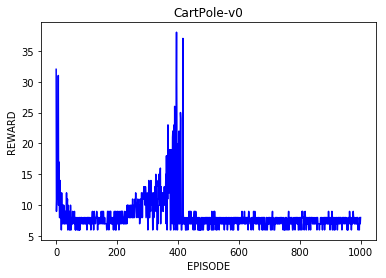

----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.92
TIMES 4
----------TRAINING----------
[ 0 ] 30.0
[ 1 ] 9.0
[ 2 ] 12.0
[ 3 ] 21.0
[ 4 ] 18.0
[ 5 ] 19.0
[ 6 ] 23.0
[ 7 ] 9.0
[ 8 ] 11.0
[ 9 ] 9.0
[ 10 ] 8.0
[ 11 ] 6.0
[ 12 ] 10.0
[ 13 ] 7.0
[ 14 ] 9.0
[ 15 ] 9.0
[ 16 ] 8.0
[ 17 ] 7.0
[ 18 ] 15.0
[ 19 ] 9.0
[ 20 ] 9.0
[ 21 ] 7.0
[ 22 ] 9.0
[ 23 ] 7.0
[ 24 ] 8.0
[ 25 ] 10.0
[ 26 ] 7.0
[ 27 ] 8.0
[ 28 ] 6.0
[ 29 ] 8.0
[ 30 ] 10.0
[ 31 ] 11.0
[ 32 ] 11.0
[ 33 ] 9.0
[ 34 ] 8.0
[ 35 ] 8.0
[ 36 ] 9.0
[ 37 ] 6.0
[ 38 ] 9.0
[ 39 ] 11.0
[ 40 ] 7.0
[ 41 ] 8.0
[ 42 ] 7.0
[ 43 ] 8.0
[ 44 ] 7.0
[ 45 ] 9.0
[ 46 ] 7.0
[ 47 ] 7.0
[ 48 ] 7.0
[ 49 ] 9.0
[ 50 ] 9.0
[ 51 ] 8.0
[ 52 ] 7.0
[ 53 ] 7.0
[ 54 ] 8.0
[ 55 ] 8.0
[ 56 ] 8.0
[ 57 ] 8.0
[ 58 ] 7.0
[ 59 ] 7.0
[ 60 ] 7.0
[ 61 ] 8.0
[ 62 ] 6.0
[ 63 ] 8.0
[ 64 ] 8.0
[ 65 ] 7.0
[ 66 ] 8.0
[ 67 ] 8.0
[ 68 ] 6.0
[ 69 ] 7.0
[ 70 ] 8.0
[ 71 ] 9.0
[ 72 ] 7.0
[ 73 ] 9.0


[ 654 ] 8.0
[ 655 ] 9.0
[ 656 ] 8.0
[ 657 ] 7.0
[ 658 ] 7.0
[ 659 ] 6.0
[ 660 ] 7.0
[ 661 ] 8.0
[ 662 ] 7.0
[ 663 ] 7.0
[ 664 ] 8.0
[ 665 ] 8.0
[ 666 ] 8.0
[ 667 ] 7.0
[ 668 ] 9.0
[ 669 ] 7.0
[ 670 ] 6.0
[ 671 ] 7.0
[ 672 ] 8.0
[ 673 ] 8.0
[ 674 ] 8.0
[ 675 ] 8.0
[ 676 ] 6.0
[ 677 ] 7.0
[ 678 ] 7.0
[ 679 ] 8.0
[ 680 ] 7.0
[ 681 ] 7.0
[ 682 ] 6.0
[ 683 ] 6.0
[ 684 ] 7.0
[ 685 ] 7.0
[ 686 ] 7.0
[ 687 ] 8.0
[ 688 ] 9.0
[ 689 ] 7.0
[ 690 ] 7.0
[ 691 ] 8.0
[ 692 ] 7.0
[ 693 ] 8.0
[ 694 ] 7.0
[ 695 ] 7.0
[ 696 ] 6.0
[ 697 ] 6.0
[ 698 ] 6.0
[ 699 ] 8.0
[ 700 ] 8.0
[ 701 ] 7.0
[ 702 ] 7.0
[ 703 ] 8.0
[ 704 ] 7.0
[ 705 ] 8.0
[ 706 ] 8.0
[ 707 ] 7.0
[ 708 ] 8.0
[ 709 ] 7.0
[ 710 ] 6.0
[ 711 ] 8.0
[ 712 ] 8.0
[ 713 ] 7.0
[ 714 ] 8.0
[ 715 ] 8.0
[ 716 ] 8.0
[ 717 ] 7.0
[ 718 ] 7.0
[ 719 ] 6.0
[ 720 ] 7.0
[ 721 ] 8.0
[ 722 ] 6.0
[ 723 ] 8.0
[ 724 ] 9.0
[ 725 ] 7.0
[ 726 ] 6.0
[ 727 ] 9.0
[ 728 ] 7.0
[ 729 ] 7.0
[ 730 ] 8.0
[ 731 ] 8.0
[ 732 ] 7.0
[ 733 ] 8.0
[ 734 ] 7.0
[ 735 ] 6.0
[ 736 ] 7.0
[ 73

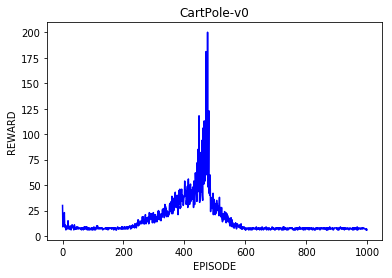

----------TESTING----------
[ 0 ] 9.0
[ 1 ] 11.0
[ 2 ] 9.0
[ 3 ] 8.0
[ 4 ] 10.0
[ 5 ] 8.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 8.0
MEANS 1.8199999999999998
TIMES 5
----------TRAINING----------
[ 0 ] 15.0
[ 1 ] 11.0
[ 2 ] 45.0
[ 3 ] 8.0
[ 4 ] 10.0
[ 5 ] 27.0
[ 6 ] 7.0
[ 7 ] 7.0
[ 8 ] 9.0
[ 9 ] 10.0
[ 10 ] 11.0
[ 11 ] 8.0
[ 12 ] 16.0
[ 13 ] 13.0
[ 14 ] 11.0
[ 15 ] 17.0
[ 16 ] 9.0
[ 17 ] 9.0
[ 18 ] 9.0
[ 19 ] 7.0
[ 20 ] 6.0
[ 21 ] 8.0
[ 22 ] 8.0
[ 23 ] 10.0
[ 24 ] 8.0
[ 25 ] 8.0
[ 26 ] 13.0
[ 27 ] 8.0
[ 28 ] 8.0
[ 29 ] 8.0
[ 30 ] 6.0
[ 31 ] 8.0
[ 32 ] 7.0
[ 33 ] 8.0
[ 34 ] 8.0
[ 35 ] 7.0
[ 36 ] 8.0
[ 37 ] 8.0
[ 38 ] 10.0
[ 39 ] 9.0
[ 40 ] 9.0
[ 41 ] 7.0
[ 42 ] 7.0
[ 43 ] 8.0
[ 44 ] 7.0
[ 45 ] 9.0
[ 46 ] 7.0
[ 47 ] 10.0
[ 48 ] 7.0
[ 49 ] 7.0
[ 50 ] 10.0
[ 51 ] 7.0
[ 52 ] 7.0
[ 53 ] 8.0
[ 54 ] 7.0
[ 55 ] 6.0
[ 56 ] 6.0
[ 57 ] 6.0
[ 58 ] 7.0
[ 59 ] 8.0
[ 60 ] 8.0
[ 61 ] 6.0
[ 62 ] 10.0
[ 63 ] 7.0
[ 64 ] 8.0
[ 65 ] 8.0
[ 66 ] 8.0
[ 67 ] 8.0
[ 68 ] 8.0
[ 69 ] 6.0
[ 70 ] 8.0
[ 71 ] 7.0
[ 72 ] 7

[ 665 ] 8.0
[ 666 ] 8.0
[ 667 ] 8.0
[ 668 ] 8.0
[ 669 ] 8.0
[ 670 ] 8.0
[ 671 ] 8.0
[ 672 ] 7.0
[ 673 ] 7.0
[ 674 ] 7.0
[ 675 ] 8.0
[ 676 ] 7.0
[ 677 ] 8.0
[ 678 ] 8.0
[ 679 ] 8.0
[ 680 ] 7.0
[ 681 ] 8.0
[ 682 ] 8.0
[ 683 ] 8.0
[ 684 ] 7.0
[ 685 ] 9.0
[ 686 ] 8.0
[ 687 ] 8.0
[ 688 ] 6.0
[ 689 ] 6.0
[ 690 ] 8.0
[ 691 ] 8.0
[ 692 ] 7.0
[ 693 ] 7.0
[ 694 ] 8.0
[ 695 ] 8.0
[ 696 ] 8.0
[ 697 ] 7.0
[ 698 ] 8.0
[ 699 ] 6.0
[ 700 ] 9.0
[ 701 ] 8.0
[ 702 ] 8.0
[ 703 ] 6.0
[ 704 ] 6.0
[ 705 ] 7.0
[ 706 ] 8.0
[ 707 ] 7.0
[ 708 ] 7.0
[ 709 ] 8.0
[ 710 ] 6.0
[ 711 ] 7.0
[ 712 ] 8.0
[ 713 ] 8.0
[ 714 ] 7.0
[ 715 ] 7.0
[ 716 ] 8.0
[ 717 ] 7.0
[ 718 ] 8.0
[ 719 ] 8.0
[ 720 ] 8.0
[ 721 ] 6.0
[ 722 ] 8.0
[ 723 ] 8.0
[ 724 ] 7.0
[ 725 ] 7.0
[ 726 ] 7.0
[ 727 ] 8.0
[ 728 ] 7.0
[ 729 ] 8.0
[ 730 ] 7.0
[ 731 ] 8.0
[ 732 ] 7.0
[ 733 ] 8.0
[ 734 ] 6.0
[ 735 ] 8.0
[ 736 ] 7.0
[ 737 ] 8.0
[ 738 ] 8.0
[ 739 ] 8.0
[ 740 ] 7.0
[ 741 ] 7.0
[ 742 ] 6.0
[ 743 ] 8.0
[ 744 ] 8.0
[ 745 ] 8.0
[ 746 ] 6.0
[ 747 ] 6.0
[ 74

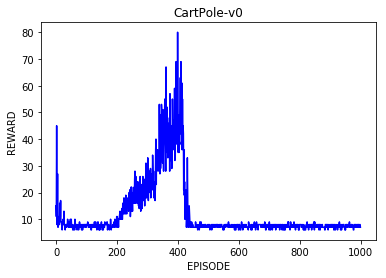

----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.9
TIMES 6
----------TRAINING----------
[ 0 ] 12.0
[ 1 ] 8.0
[ 2 ] 10.0
[ 3 ] 17.0
[ 4 ] 19.0
[ 5 ] 22.0
[ 6 ] 7.0
[ 7 ] 8.0
[ 8 ] 8.0
[ 9 ] 8.0
[ 10 ] 12.0
[ 11 ] 30.0
[ 12 ] 7.0
[ 13 ] 14.0
[ 14 ] 10.0
[ 15 ] 10.0
[ 16 ] 9.0
[ 17 ] 8.0
[ 18 ] 12.0
[ 19 ] 7.0
[ 20 ] 10.0
[ 21 ] 11.0
[ 22 ] 7.0
[ 23 ] 8.0
[ 24 ] 8.0
[ 25 ] 7.0
[ 26 ] 9.0
[ 27 ] 6.0
[ 28 ] 7.0
[ 29 ] 10.0
[ 30 ] 7.0
[ 31 ] 9.0
[ 32 ] 7.0
[ 33 ] 8.0
[ 34 ] 11.0
[ 35 ] 7.0
[ 36 ] 8.0
[ 37 ] 10.0
[ 38 ] 8.0
[ 39 ] 7.0
[ 40 ] 8.0
[ 41 ] 7.0
[ 42 ] 7.0
[ 43 ] 7.0
[ 44 ] 7.0
[ 45 ] 12.0
[ 46 ] 8.0
[ 47 ] 6.0
[ 48 ] 7.0
[ 49 ] 7.0
[ 50 ] 8.0
[ 51 ] 8.0
[ 52 ] 7.0
[ 53 ] 7.0
[ 54 ] 8.0
[ 55 ] 7.0
[ 56 ] 7.0
[ 57 ] 7.0
[ 58 ] 8.0
[ 59 ] 11.0
[ 60 ] 8.0
[ 61 ] 7.0
[ 62 ] 7.0
[ 63 ] 8.0
[ 64 ] 8.0
[ 65 ] 7.0
[ 66 ] 8.0
[ 67 ] 8.0
[ 68 ] 8.0
[ 69 ] 8.0
[ 70 ] 8.0
[ 71 ] 8.0
[ 72 ] 8.0
[ 73 ] 6.

[ 661 ] 7.0
[ 662 ] 7.0
[ 663 ] 7.0
[ 664 ] 7.0
[ 665 ] 8.0
[ 666 ] 8.0
[ 667 ] 8.0
[ 668 ] 8.0
[ 669 ] 8.0
[ 670 ] 9.0
[ 671 ] 7.0
[ 672 ] 8.0
[ 673 ] 8.0
[ 674 ] 8.0
[ 675 ] 7.0
[ 676 ] 7.0
[ 677 ] 7.0
[ 678 ] 8.0
[ 679 ] 8.0
[ 680 ] 8.0
[ 681 ] 7.0
[ 682 ] 7.0
[ 683 ] 7.0
[ 684 ] 8.0
[ 685 ] 8.0
[ 686 ] 7.0
[ 687 ] 8.0
[ 688 ] 8.0
[ 689 ] 8.0
[ 690 ] 7.0
[ 691 ] 7.0
[ 692 ] 6.0
[ 693 ] 8.0
[ 694 ] 7.0
[ 695 ] 6.0
[ 696 ] 8.0
[ 697 ] 7.0
[ 698 ] 8.0
[ 699 ] 8.0
[ 700 ] 8.0
[ 701 ] 8.0
[ 702 ] 8.0
[ 703 ] 8.0
[ 704 ] 7.0
[ 705 ] 8.0
[ 706 ] 7.0
[ 707 ] 7.0
[ 708 ] 8.0
[ 709 ] 8.0
[ 710 ] 8.0
[ 711 ] 7.0
[ 712 ] 7.0
[ 713 ] 8.0
[ 714 ] 8.0
[ 715 ] 7.0
[ 716 ] 7.0
[ 717 ] 7.0
[ 718 ] 8.0
[ 719 ] 7.0
[ 720 ] 8.0
[ 721 ] 8.0
[ 722 ] 8.0
[ 723 ] 7.0
[ 724 ] 8.0
[ 725 ] 7.0
[ 726 ] 7.0
[ 727 ] 7.0
[ 728 ] 7.0
[ 729 ] 8.0
[ 730 ] 7.0
[ 731 ] 8.0
[ 732 ] 7.0
[ 733 ] 6.0
[ 734 ] 8.0
[ 735 ] 8.0
[ 736 ] 8.0
[ 737 ] 8.0
[ 738 ] 7.0
[ 739 ] 7.0
[ 740 ] 7.0
[ 741 ] 7.0
[ 742 ] 8.0
[ 743 ] 7.0
[ 74

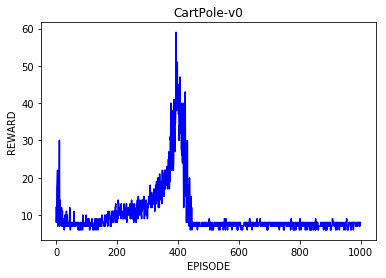

----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 8.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.92
TIMES 7
----------TRAINING----------
[ 0 ] 22.0
[ 1 ] 12.0
[ 2 ] 28.0
[ 3 ] 38.0
[ 4 ] 8.0
[ 5 ] 12.0
[ 6 ] 14.0
[ 7 ] 9.0
[ 8 ] 26.0
[ 9 ] 12.0
[ 10 ] 10.0
[ 11 ] 8.0
[ 12 ] 7.0
[ 13 ] 16.0
[ 14 ] 8.0
[ 15 ] 11.0
[ 16 ] 8.0
[ 17 ] 9.0
[ 18 ] 8.0
[ 19 ] 8.0
[ 20 ] 10.0
[ 21 ] 6.0
[ 22 ] 8.0
[ 23 ] 9.0
[ 24 ] 6.0
[ 25 ] 8.0
[ 26 ] 8.0
[ 27 ] 6.0
[ 28 ] 7.0
[ 29 ] 7.0
[ 30 ] 8.0
[ 31 ] 7.0
[ 32 ] 8.0
[ 33 ] 6.0
[ 34 ] 12.0
[ 35 ] 7.0
[ 36 ] 8.0
[ 37 ] 6.0
[ 38 ] 8.0
[ 39 ] 7.0
[ 40 ] 7.0
[ 41 ] 7.0
[ 42 ] 8.0
[ 43 ] 8.0
[ 44 ] 7.0
[ 45 ] 6.0
[ 46 ] 7.0
[ 47 ] 7.0
[ 48 ] 7.0
[ 49 ] 8.0
[ 50 ] 8.0
[ 51 ] 8.0
[ 52 ] 7.0
[ 53 ] 8.0
[ 54 ] 7.0
[ 55 ] 7.0
[ 56 ] 10.0
[ 57 ] 8.0
[ 58 ] 8.0
[ 59 ] 8.0
[ 60 ] 8.0
[ 61 ] 8.0
[ 62 ] 8.0
[ 63 ] 7.0
[ 64 ] 8.0
[ 65 ] 8.0
[ 66 ] 8.0
[ 67 ] 7.0
[ 68 ] 8.0
[ 69 ] 8.0
[ 70 ] 8.0
[ 71 ] 7.0
[ 72 ] 7.0
[ 73 ] 7.0

[ 663 ] 7.0
[ 664 ] 8.0
[ 665 ] 7.0
[ 666 ] 6.0
[ 667 ] 8.0
[ 668 ] 7.0
[ 669 ] 6.0
[ 670 ] 8.0
[ 671 ] 6.0
[ 672 ] 9.0
[ 673 ] 8.0
[ 674 ] 9.0
[ 675 ] 8.0
[ 676 ] 8.0
[ 677 ] 6.0
[ 678 ] 7.0
[ 679 ] 7.0
[ 680 ] 8.0
[ 681 ] 7.0
[ 682 ] 8.0
[ 683 ] 7.0
[ 684 ] 8.0
[ 685 ] 8.0
[ 686 ] 7.0
[ 687 ] 8.0
[ 688 ] 8.0
[ 689 ] 8.0
[ 690 ] 8.0
[ 691 ] 7.0
[ 692 ] 8.0
[ 693 ] 7.0
[ 694 ] 7.0
[ 695 ] 8.0
[ 696 ] 7.0
[ 697 ] 7.0
[ 698 ] 9.0
[ 699 ] 7.0
[ 700 ] 8.0
[ 701 ] 8.0
[ 702 ] 7.0
[ 703 ] 6.0
[ 704 ] 7.0
[ 705 ] 8.0
[ 706 ] 8.0
[ 707 ] 8.0
[ 708 ] 7.0
[ 709 ] 8.0
[ 710 ] 8.0
[ 711 ] 7.0
[ 712 ] 8.0
[ 713 ] 7.0
[ 714 ] 8.0
[ 715 ] 7.0
[ 716 ] 7.0
[ 717 ] 8.0
[ 718 ] 8.0
[ 719 ] 8.0
[ 720 ] 7.0
[ 721 ] 7.0
[ 722 ] 8.0
[ 723 ] 8.0
[ 724 ] 7.0
[ 725 ] 6.0
[ 726 ] 7.0
[ 727 ] 9.0
[ 728 ] 8.0
[ 729 ] 7.0
[ 730 ] 7.0
[ 731 ] 8.0
[ 732 ] 7.0
[ 733 ] 6.0
[ 734 ] 8.0
[ 735 ] 8.0
[ 736 ] 8.0
[ 737 ] 7.0
[ 738 ] 8.0
[ 739 ] 8.0
[ 740 ] 7.0
[ 741 ] 6.0
[ 742 ] 8.0
[ 743 ] 7.0
[ 744 ] 8.0
[ 745 ] 7.0
[ 74

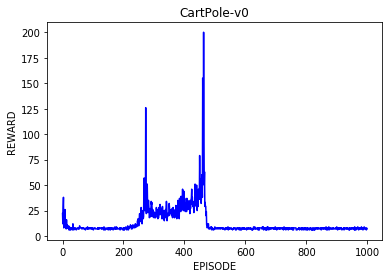

----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 10.0
[ 4 ] 8.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.86
TIMES 8
----------TRAINING----------
[ 0 ] 10.0
[ 1 ] 14.0
[ 2 ] 16.0
[ 3 ] 33.0
[ 4 ] 13.0
[ 5 ] 9.0
[ 6 ] 7.0
[ 7 ] 10.0
[ 8 ] 13.0
[ 9 ] 15.0
[ 10 ] 13.0
[ 11 ] 15.0
[ 12 ] 7.0
[ 13 ] 6.0
[ 14 ] 7.0
[ 15 ] 14.0
[ 16 ] 12.0
[ 17 ] 11.0
[ 18 ] 6.0
[ 19 ] 9.0
[ 20 ] 7.0
[ 21 ] 10.0
[ 22 ] 7.0
[ 23 ] 9.0
[ 24 ] 10.0
[ 25 ] 9.0
[ 26 ] 7.0
[ 27 ] 8.0
[ 28 ] 7.0
[ 29 ] 7.0
[ 30 ] 7.0
[ 31 ] 7.0
[ 32 ] 8.0
[ 33 ] 9.0
[ 34 ] 9.0
[ 35 ] 11.0
[ 36 ] 10.0
[ 37 ] 10.0
[ 38 ] 8.0
[ 39 ] 8.0
[ 40 ] 8.0
[ 41 ] 8.0
[ 42 ] 7.0
[ 43 ] 6.0
[ 44 ] 8.0
[ 45 ] 9.0
[ 46 ] 9.0
[ 47 ] 8.0
[ 48 ] 8.0
[ 49 ] 8.0
[ 50 ] 11.0
[ 51 ] 10.0
[ 52 ] 10.0
[ 53 ] 8.0
[ 54 ] 7.0
[ 55 ] 7.0
[ 56 ] 9.0
[ 57 ] 8.0
[ 58 ] 9.0
[ 59 ] 6.0
[ 60 ] 8.0
[ 61 ] 7.0
[ 62 ] 8.0
[ 63 ] 8.0
[ 64 ] 8.0
[ 65 ] 7.0
[ 66 ] 6.0
[ 67 ] 8.0
[ 68 ] 8.0
[ 69 ] 6.0
[ 70 ] 8.0
[ 71 ] 8.0
[ 72 ] 6.0
[ 73 ]

[ 649 ] 8.0
[ 650 ] 8.0
[ 651 ] 8.0
[ 652 ] 7.0
[ 653 ] 8.0
[ 654 ] 8.0
[ 655 ] 8.0
[ 656 ] 7.0
[ 657 ] 7.0
[ 658 ] 8.0
[ 659 ] 8.0
[ 660 ] 8.0
[ 661 ] 8.0
[ 662 ] 8.0
[ 663 ] 8.0
[ 664 ] 8.0
[ 665 ] 8.0
[ 666 ] 6.0
[ 667 ] 7.0
[ 668 ] 8.0
[ 669 ] 6.0
[ 670 ] 8.0
[ 671 ] 8.0
[ 672 ] 7.0
[ 673 ] 7.0
[ 674 ] 8.0
[ 675 ] 6.0
[ 676 ] 8.0
[ 677 ] 7.0
[ 678 ] 6.0
[ 679 ] 8.0
[ 680 ] 8.0
[ 681 ] 7.0
[ 682 ] 7.0
[ 683 ] 8.0
[ 684 ] 7.0
[ 685 ] 8.0
[ 686 ] 7.0
[ 687 ] 7.0
[ 688 ] 8.0
[ 689 ] 8.0
[ 690 ] 7.0
[ 691 ] 7.0
[ 692 ] 8.0
[ 693 ] 7.0
[ 694 ] 7.0
[ 695 ] 7.0
[ 696 ] 7.0
[ 697 ] 7.0
[ 698 ] 8.0
[ 699 ] 7.0
[ 700 ] 8.0
[ 701 ] 7.0
[ 702 ] 6.0
[ 703 ] 8.0
[ 704 ] 8.0
[ 705 ] 7.0
[ 706 ] 8.0
[ 707 ] 8.0
[ 708 ] 6.0
[ 709 ] 7.0
[ 710 ] 8.0
[ 711 ] 8.0
[ 712 ] 9.0
[ 713 ] 8.0
[ 714 ] 7.0
[ 715 ] 6.0
[ 716 ] 8.0
[ 717 ] 8.0
[ 718 ] 7.0
[ 719 ] 8.0
[ 720 ] 8.0
[ 721 ] 8.0
[ 722 ] 8.0
[ 723 ] 7.0
[ 724 ] 7.0
[ 725 ] 8.0
[ 726 ] 8.0
[ 727 ] 7.0
[ 728 ] 6.0
[ 729 ] 7.0
[ 730 ] 7.0
[ 731 ] 7.0
[ 73

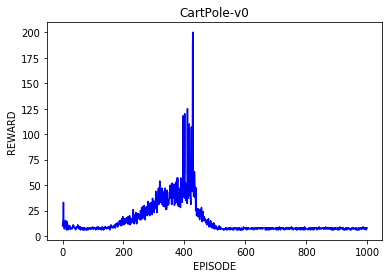

----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 8.0
[ 9 ] 9.0
MEANS 1.8399999999999999
TIMES 9
----------TRAINING----------
[ 0 ] 12.0
[ 1 ] 24.0
[ 2 ] 8.0
[ 3 ] 16.0
[ 4 ] 12.0
[ 5 ] 19.0
[ 6 ] 10.0
[ 7 ] 30.0
[ 8 ] 7.0
[ 9 ] 11.0
[ 10 ] 9.0
[ 11 ] 9.0
[ 12 ] 6.0
[ 13 ] 8.0
[ 14 ] 8.0
[ 15 ] 12.0
[ 16 ] 6.0
[ 17 ] 10.0
[ 18 ] 14.0
[ 19 ] 8.0
[ 20 ] 9.0
[ 21 ] 10.0
[ 22 ] 6.0
[ 23 ] 8.0
[ 24 ] 7.0
[ 25 ] 9.0
[ 26 ] 9.0
[ 27 ] 8.0
[ 28 ] 7.0
[ 29 ] 10.0
[ 30 ] 10.0
[ 31 ] 6.0
[ 32 ] 7.0
[ 33 ] 9.0
[ 34 ] 7.0
[ 35 ] 7.0
[ 36 ] 9.0
[ 37 ] 8.0
[ 38 ] 7.0
[ 39 ] 9.0
[ 40 ] 8.0
[ 41 ] 8.0
[ 42 ] 7.0
[ 43 ] 7.0
[ 44 ] 7.0
[ 45 ] 6.0
[ 46 ] 7.0
[ 47 ] 7.0
[ 48 ] 8.0
[ 49 ] 8.0
[ 50 ] 7.0
[ 51 ] 7.0
[ 52 ] 8.0
[ 53 ] 6.0
[ 54 ] 8.0
[ 55 ] 8.0
[ 56 ] 6.0
[ 57 ] 8.0
[ 58 ] 8.0
[ 59 ] 8.0
[ 60 ] 8.0
[ 61 ] 7.0
[ 62 ] 8.0
[ 63 ] 8.0
[ 64 ] 8.0
[ 65 ] 8.0
[ 66 ] 8.0
[ 67 ] 8.0
[ 68 ] 8.0
[ 69 ] 8.0
[ 70 ] 8.0
[ 71 ] 7.0
[ 72 ] 8.0


[ 655 ] 7.0
[ 656 ] 8.0
[ 657 ] 9.0
[ 658 ] 7.0
[ 659 ] 7.0
[ 660 ] 8.0
[ 661 ] 6.0
[ 662 ] 7.0
[ 663 ] 9.0
[ 664 ] 7.0
[ 665 ] 8.0
[ 666 ] 7.0
[ 667 ] 6.0
[ 668 ] 8.0
[ 669 ] 7.0
[ 670 ] 7.0
[ 671 ] 7.0
[ 672 ] 7.0
[ 673 ] 8.0
[ 674 ] 7.0
[ 675 ] 8.0
[ 676 ] 6.0
[ 677 ] 6.0
[ 678 ] 6.0
[ 679 ] 8.0
[ 680 ] 7.0
[ 681 ] 8.0
[ 682 ] 7.0
[ 683 ] 8.0
[ 684 ] 7.0
[ 685 ] 8.0
[ 686 ] 7.0
[ 687 ] 8.0
[ 688 ] 8.0
[ 689 ] 9.0
[ 690 ] 6.0
[ 691 ] 7.0
[ 692 ] 7.0
[ 693 ] 6.0
[ 694 ] 8.0
[ 695 ] 7.0
[ 696 ] 7.0
[ 697 ] 8.0
[ 698 ] 7.0
[ 699 ] 7.0
[ 700 ] 6.0
[ 701 ] 6.0
[ 702 ] 7.0
[ 703 ] 8.0
[ 704 ] 7.0
[ 705 ] 7.0
[ 706 ] 7.0
[ 707 ] 8.0
[ 708 ] 8.0
[ 709 ] 8.0
[ 710 ] 8.0
[ 711 ] 7.0
[ 712 ] 8.0
[ 713 ] 7.0
[ 714 ] 8.0
[ 715 ] 7.0
[ 716 ] 6.0
[ 717 ] 8.0
[ 718 ] 8.0
[ 719 ] 7.0
[ 720 ] 8.0
[ 721 ] 8.0
[ 722 ] 7.0
[ 723 ] 7.0
[ 724 ] 8.0
[ 725 ] 7.0
[ 726 ] 9.0
[ 727 ] 6.0
[ 728 ] 8.0
[ 729 ] 7.0
[ 730 ] 8.0
[ 731 ] 7.0
[ 732 ] 6.0
[ 733 ] 8.0
[ 734 ] 7.0
[ 735 ] 7.0
[ 736 ] 7.0
[ 737 ] 7.0
[ 73

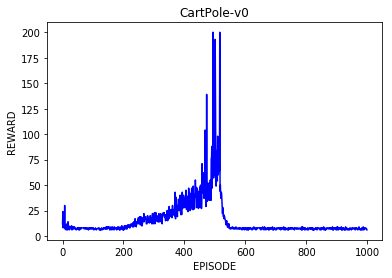

----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.9


<Figure size 432x288 with 0 Axes>

In [30]:
# main
numAction = environment.action_space.n
numState = environment.observation_space.shape[0]

for times in range(10):
    print('TIMES', times)

    dqn = DQN(numState, numAction)
    scoreArray = []

    # training
    print('----------TRAINING----------')
    for i in range(TRAIN_EPISODE):
        state = environment.reset()
        totalReward = 0

        while True:
            action = dqn.chooseAction(state)
            state2, reward, done, info = environment.step(action)
            reward = -1 if done else reward
            dqn.storeTransition(state, action, reward, state2)

            totalReward += reward
            dqn.learn()

            if done or totalReward >= 200:
                print('[', i, ']', round(totalReward, 2))
                break

            state = state2
        scoreArray.append(totalReward)

    # show result
    matplotlib.pyplot.plot(range(0, len(scoreArray)), scoreArray, color="#0000FF")
    matplotlib.pyplot.title('CartPole-v0')
    matplotlib.pyplot.xlabel('EPISODE')
    matplotlib.pyplot.ylabel('REWARD')
    matplotlib.pyplot.show()
    matplotlib.pyplot.clf()

    # testing
    print('----------TESTING----------')
    scoreArray = []
    for i in range(TEST_EPISODE):
        state = environment.reset()
        totalReward = 0

        while True:
            action = dqn.chooseAction(state)
            state2, reward, done, info = environment.step(action)

            totalReward += reward

            if done or totalReward >= 200:
                print('[', i, ']', totalReward)
                break

            state = state2
        scoreArray.append(totalReward)

    # show result
    print('MEANS', (sum(scoreArray) / len(scoreArray)) / 5)

In [39]:
for times in range(1000):
    # testing
    print('----------TESTING----------')
    scoreArray = []
    for i in range(TEST_EPISODE):
        state = environment.reset()
        totalReward = 0

        while True:
            action = dqn.chooseAction(state)
            state2, reward, done, info = environment.step(action)

            totalReward += reward

            if done or totalReward >= 200:
                print('[', i, ']', totalReward)
                break

            state = state2
        scoreArray.append(totalReward)

    # show result
    if((sum(scoreArray) / len(scoreArray)) / 5>2):
        print('---------------RESULT---------------')
    print('MEANS', (sum(scoreArray) / len(scoreArray)) / 5)

----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 8.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 11.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.9
----------TESTING----------
[ 0 ] 11.0
[ 1 ] 10.0
[ 2 ] 10.0
[ 3 ] 8.0
[ 4 ] 9.0
[ 5 ] 8.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 11.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 11.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.9600000000000002
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 8.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 8.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 9.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 8.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.9
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.86
----------TESTING----------
[ 0 ] 11.0
[ 1 ] 9.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 

[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.86
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 11.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 8.0
[ 9 ] 10.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 8.0
[ 2 ] 8.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 8.0
[ 7 ] 9.0
[ 8 ] 8.0
[ 9 ] 10.0
MEANS 1.8
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 9.0
[ 3 ] 8.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 11.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 11.0
[ 9 ] 10.0
MEANS 1.9600000000000002
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 9.0
MEANS 1.92
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 8.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.86
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 9

[ 8 ] 9.0
[ 9 ] 9.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 8.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 8.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 11.0
MEANS 1.92
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 11.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.92
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 11.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 8.0
[ 9 ] 9.0
MEANS 1.8199999999999998
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 11.0
[ 6 ] 10.0
[ 7 ] 8.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.9
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 

[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 8.0
MEANS 1.7399999999999998
----------TESTING----------
[ 0 ] 11.0
[ 1 ] 9.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 8.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 8.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.86
----------TESTING----------
[ 0 ] 8.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 9.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 11.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 9.0
[ 6 ] 8.0
[ 7 ] 8.0
[ 8 ] 9.0
[ 9 ] 9.0
MEANS 1.86
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 8.0
[ 9 ] 9.0
MEANS 1.8800000000000001
----------TESTING----------
[

[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 8.0
[ 6 ] 8.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 9.0
MEANS 1.8
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 8.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 8.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 8.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.86
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 8.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 11.0
[ 9 ] 9.0
MEANS 1.92
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 8.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 9.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 11.0
[ 8 ] 10.0
[ 9 ] 8.0
MEANS 1.92
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 8.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 11.0
MEANS 1

[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.86
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 8.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.9
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 11.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.94
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 8.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.9
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 8.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 8.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 8.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 8.0
MEANS 1.86
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 11.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 11.0
MEANS 1.98
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 8.0
[ 4 ] 9.0
[ 5 ] 9.0

[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 11.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.9600000000000002
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 8.0
MEANS 1.86
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 8.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.9
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 8.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.94
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 8.0
[ 7 ] 8.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 8.0
[ 8 ] 8.0
[ 9 ] 10.0
MEANS 1.86
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 8.0
[ 4 ] 10.0
[ 5 ] 11.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 8.0
[ 9 ] 10.0
MEANS 1.9
----------TESTING----

[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.9
----------TESTING----------
[ 0 ] 11.0
[ 1 ] 11.0
[ 2 ] 8.0
[ 3 ] 10.0
[ 4 ] 8.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 8.0
MEANS 1.9
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 11.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.92
----------TESTING----------
[ 0 ] 8.0
[ 1 ] 10.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 8.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.86
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 8.0
[ 6 ] 10.0
[ 7 ] 8.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 8.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 8.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 

[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.9600000000000002
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 11.0
[ 7 ] 8.0
[ 8 ] 10.0
[ 9 ] 8.0
MEANS 1.9
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 8.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 9.0
MEANS 1.86
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 8.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 11.0
[ 9 ] 9.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 8.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 8.0
[ 7 ] 9.0
[ 8 ] 8.0
[ 9 ] 9.0
MEANS 1.7600000000000002
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 8.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 8.0
[ 7 ] 10.0
[ 8 ] 8.0
[ 9 ] 10.0
MEANS 1.86
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 11.0
[ 7 ] 12.0
[ 8 ] 9.0
[ 9 ] 8.0
MEANS 1.92
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 8.0
[ 3 ] 9.0


[ 0 ] 8.0
[ 1 ] 10.0
[ 2 ] 8.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 12.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.94
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 12.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 8.0
[ 8 ] 9.0
[ 9 ] 11.0
MEANS 1.92
----------TESTING----------
[ 0 ] 8.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 8.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.86
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 8.0
[ 3 ] 9.0
[ 4 ] 8.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.92
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 8.0
[ 5 ] 10.0
[ 6 ] 11.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 8.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 8.0
[ 6 ] 9.0
[ 7 ] 8.0
[ 8 ] 8.0
[ 9 ] 8.0
MEAN

[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.92
----------TESTING----------
[ 0 ] 8.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 8.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 8.0
MEANS 1.78
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 8.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 8.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.86
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.94
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 8.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 8.0
[ 8 ] 9.0
[ 9 ] 9.0
MEANS 1.8199999999999998
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 10.0
[ 3 ] 11.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 11.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS

[ 8 ] 8.0
[ 9 ] 10.0
MEANS 1.86
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 8.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 8.0
[ 3 ] 8.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 8.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.8199999999999998
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.92
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 8.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 8.0
[ 2 ] 9.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 8.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 9.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 10

[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 8.0
[ 2 ] 10.0
[ 3 ] 8.0
[ 4 ] 10.0
[ 5 ] 11.0
[ 6 ] 8.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 9.0
MEANS 1.86
----------TESTING----------
[ 0 ] 8.0
[ 1 ] 8.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 8.0
[ 9 ] 9.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 8.0
[ 1 ] 10.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 8.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 8.0
[ 9 ] 10.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 11.0
[ 3 ] 8.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 8.0
[ 8 ] 10.0
[ 9 ] 8.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 8.0
[ 2 ] 8.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 8.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 8.0
[ 9 ] 9.0
MEANS 1.8199999999999998
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 8.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 10.0
MEAN

[ 4 ] 10.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 8.0
MEANS 1.86
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 8.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 8.0
MEANS 1.86
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 8.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 8.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 8.0
[ 5 ] 8.0
[ 6 ] 8.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.8
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 8.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.86
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.9
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.9
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ]

[ 2 ] 9.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.9600000000000002
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 8.0
[ 9 ] 8.0
MEANS 1.8199999999999998
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.92
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 8.0
[ 2 ] 9.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 8.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.86
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.9600000000000002
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 11.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.92
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 10.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 9.0
MEANS 1

[ 8 ] 9.0
[ 9 ] 9.0
MEANS 1.9
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 8.0
[ 2 ] 8.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.8199999999999998
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 9.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 8.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 8.0
[ 1 ] 8.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 8.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 8.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.8199999999999998
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 9.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 8.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 8.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.8800000000000001
----------TESTING----------

[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.92
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 11.0
[ 9 ] 10.0
MEANS 1.92
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 8.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 9.0
MEANS 1.86
----------TESTING----------
[ 0 ] 8.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 8.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 11.0
[ 2 ] 9.0
[ 3 ] 10.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.94
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 8.0
[ 5 ] 8.0
[ 6 ] 10.0
[ 7 ] 9.0
[ 8 ] 8.0
[ 9 ] 10.0
MEANS 1.8199999999999998
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 10.0
[ 2 ] 8.0
[ 3 ] 9.0
[ 4 ] 8.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 10.0
[ 9 ] 10.0
MEANS 1.8399999999999999
----------TESTING----------
[ 0 ] 11.0
[ 1 ] 9.0
[ 2 ] 9.0
[ 3 ]

[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 9.0
[ 6 ] 9.0
[ 7 ] 9.0
[ 8 ] 9.0
[ 9 ] 10.0
MEANS 1.86
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 10.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 10.0
[ 7 ] 8.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.92
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 8.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 11.0
[ 8 ] 8.0
[ 9 ] 9.0
MEANS 1.86
----------TESTING----------
[ 0 ] 10.0
[ 1 ] 9.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 11.0
[ 8 ] 9.0
[ 9 ] 9.0
MEANS 1.8800000000000001
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 9.0
[ 3 ] 9.0
[ 4 ] 10.0
[ 5 ] 10.0
[ 6 ] 9.0
[ 7 ] 10.0
[ 8 ] 9.0
[ 9 ] 9.0
MEANS 1.86
----------TESTING----------
[ 0 ] 9.0
[ 1 ] 9.0
[ 2 ] 10.0
[ 3 ] 9.0
[ 4 ] 9.0
[ 5 ] 9.0
[ 6 ] 10.0
[ 7 ] 10.0
[ 8 ] 10.0
[ 9 ] 9.0
MEANS 1.8800000000000001
----------TEST